In [2]:
import torch
from torchdiffeq import odeint
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time, os, sys
import numpy as np
import pickle
from scripts.utils import set_seed
from scripts.ds_class import *
from scripts.homeos import *
from scripts.plotting import *
from scripts.fit_motif import *
from scripts.time_series import *
from scripts.exp_tools import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import seaborn as sns

set_seed(313)
save_dir = 'experiments/all_sources'
fig_dir = 'figures/all_sources'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

dt=0.01
time_span=torch.tensor([0, 1])
simulation_params = {
        'initial_conditions_mode': 'random',
        'number_of_target_trajectories': 50,
        'time_span': time_span,
        'dt': dt,
        'noise_std': 0.0,
        'training_pairs': False,
        'margin': 0.5,
        'seed': 42,
        'train_ratio': .8    }

def torus_4d_to_3d(torus_4d: np.ndarray, R: float = 2.0, r: float = 1.0) -> np.ndarray:
    """
    Converts 4D embedded torus points (cosθ, sinθ, cosφ, sinφ) into 3D torus coordinates.
    
    Args:
        torus_4d: np.ndarray of shape (N, 4)
        R: Major radius of the torus
        r: Minor radius of the torus

    Returns:
        np.ndarray of shape (N, 3)
    """
    x1, x2, x3, x4 = torus_4d[:, 0], torus_4d[:, 1], torus_4d[:, 2], torus_4d[:, 3]

    theta = np.arctan2(x2, x1)
    phi = np.arctan2(x4, x3)

    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.stack([x, y, z], axis=-1)


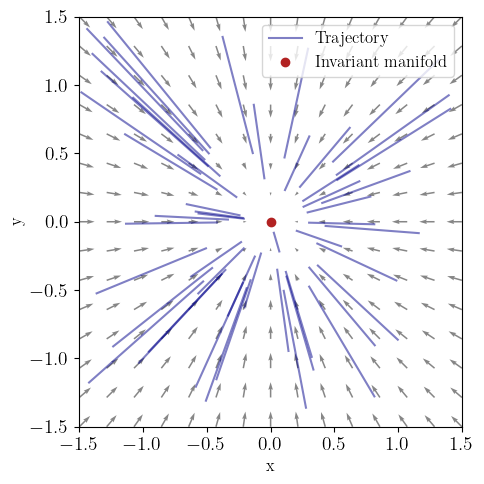

In [5]:
### LDS / 1 fixed point
dim=2
dt=0.01
time_span=torch.tensor([0, 1])
#make system 
generator_sys = LearnableNDLinearSystem(dim=dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=50, bounds=[(-1.5, 1.5)]*2, seed=simulation_params['seed'])
traj = generator_sys.compute_trajectory(init_conds).detach().numpy()

X, Y, U, V = get_ds_vf(generator_sys, bounds=[-1.5, 1.5], num_points=15)
magnitude = np.sqrt(U**2 + V**2)
max_magnitude = 1.0 # Clip VF magnitudes for visualization
scaling = np.minimum(1.0, max_magnitude / (magnitude + 1e-8))  # avoid division by zero
U_clipped = U * scaling
V_clipped = V * scaling
inv_man = generator_sys.invariant_manifold().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U_clipped, V_clipped, color='gray', alpha=0.95, scale=25)
for i in range(0, len(traj)):
    ax.plot(traj[i, :, 0], traj[i, :, 1], '-', color='darkblue', markersize=2, alpha=0.5, label='Trajectory' if i==0 else "")


ax.scatter(inv_man[0], inv_man[1], color='firebrick', zorder=10, label='Invariant manifold');
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'lds_2d.pdf'), dpi=300)

## Bistable

In [ ]:
dim=2
dt=0.01
time_span=torch.tensor([0, 1])
#make system 
generator_sys = LearnableNDBistableSystem(dim=dim, dt=dt, time_span=time_span, alpha_init=-3) 
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=50, bounds=[(-1.5, 1.5)]*2, seed=simulation_params['seed'])
bi_traj = generator_sys.compute_trajectory(init_conds).detach().numpy()

X, Y, U, V = get_ds_vf(generator_sys, bounds=[-1.5, 1.5], num_points=15)
magnitude = np.sqrt(U**2 + V**2)
max_magnitude = 1.0 # Clip VF magnitudes for visualization
scaling = np.minimum(1.0, max_magnitude / (magnitude + 1e-8))  # avoid division by zero
U_clipped = U * scaling
V_clipped = V * scaling
inv_man = generator_sys.invariant_manifold().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U_clipped, V_clipped, color='gray', alpha=0.95, scale=25)
for i in range(0, len(bi_traj)):
    ax.plot(bi_traj[i, :, 0], bi_traj[i, :, 1], '-', color='darkblue', markersize=2, alpha=0.5, label='Trajectory' if i==0 else "")

ax.scatter(inv_man[0,0], inv_man[0,1], color='firebrick', zorder=10);
ax.scatter(inv_man[1,0], inv_man[1,1], color='firebrick', zorder=10, label='Invariant manifold');
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'bistable_2d.pdf'), dpi=300)

## Limit cycle

In [ ]:
dt = 0.01
dim = 2
time_span = torch.tensor([0.0, 5.])
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=25, bounds=[(-1.5, 1.5)]*dim, seed=simulation_params['seed'])
generator_sys = LearnableNDLimitCycle(dim=dim, dt=dt, time_span=time_span, velocity_init=None, alpha_init=None)
trajectories = generator_sys.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_sys.invariant_manifold().detach().numpy()

X, Y, U, V = get_ds_vf(generator_sys, bounds=[-1.5, 1.5], num_points=15)
magnitude = np.sqrt(U**2 + V**2)
max_magnitude = 1.0 # Clip VF magnitudes for visualization
scaling = np.minimum(1.0, max_magnitude / (magnitude + 1e-8))  # avoid division by zero
U_clipped, V_clipped = U * scaling, V * scaling
inv_man = generator_sys.invariant_manifold().detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U_clipped, V_clipped, color='gray', alpha=0.95, scale=25)
for i in range(0, len(trajectories)):
    ax.plot(trajectories[i, :, 0], trajectories[i, :, 1], '-', color='darkblue', markersize=2, alpha=0.5, label='Trajectory' if i==0 else "")

ax.plot(inv_man[:,0], inv_man[:,1], color='firebrick', lw=2, zorder=10, label='Invariant manifold');
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'lc_2d.pdf'), dpi=300)

In [ ]:
# dt = 0.01
# time_span = torch.tensor([0.0, 2.])
# init_conds = generate_initial_conditions(sampling_method='uniform', num_points=100, bounds=[(-1.5, 1.5)]*3, seed=simulation_params['seed'])
# generator_ra = AnalyticalLimitCycle(dim=3, dt=dt, time_span=time_span, velocity_init=-1, alpha_init=-1)
# print(generator_ra.dim)
# alc = generator_ra.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
# plot_trajectories_3d([alc], elev=45, azim=90)
# # fig, ax = plt.subplots(figsize=(5, 5))
# # for i in range(alc.shape[0]):
# #     if i % 10 == 0:
# #         ax.plot(alc[i, :, 0], alc[i, :, 1], 'o', color='black', markersize=2, alpha=0.5)
# # plt.show()
# # fig, ax = plt.subplots(figsize=(5, 5))
# # for i in range(alc.shape[0]):
# #     if i % 10 == 0:
# #         ax.plot(alc[i, :, 2],'o', color='black', markersize=2, alpha=0.5)
# # plt.show()

## Ring attractor

In [ ]:
time_span = torch.tensor([0.0, 5.])
generator_sys = LearnableNDRingAttractor(dim=2, dt=dt, time_span=time_span)
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=50, bounds=[(-1.5, 1.5)]*2, seed=simulation_params['seed'])
ra_trajs = generator_sys.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_sys.invariant_manifold().detach().numpy();
X, Y, U, V = get_ds_vf(generator_sys, bounds=[-1.5, 1.5], num_points=1)
magnitude = np.sqrt(U**2 + V**2)
max_magnitude = .2
scaling = np.minimum(1.0, max_magnitude / (magnitude + 1e-8))  # avoid division by zero
U_clipped, V_clipped = U * scaling, V * scaling
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U_clipped, V_clipped, color='gray', alpha=0.95, scale=5)
for i in range(0, len(ra_trajs)):
    ax.plot(ra_trajs[i, :, 0], ra_trajs[i, :, 1], '-', color='darkblue', markersize=2, alpha=0.5)
ax.plot(inv_man[:,0], inv_man[:,1], color='firebrick', lw=2, zorder=10, label='Invariant manifold');
plt.savefig(os.path.join(fig_dir, 'ra_2d.pdf'), dpi=300)

# Bounded Line Attractor (BLA)

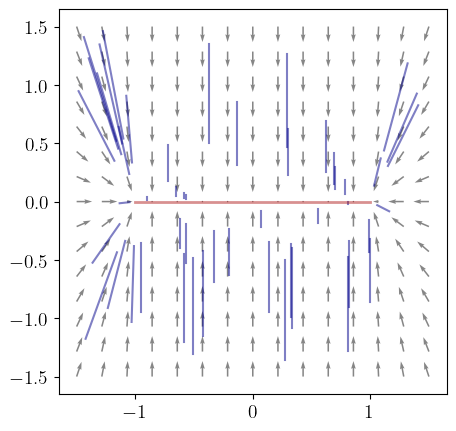

In [13]:
dim = 2
bca_dim = 1
generator_bla = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bla_trajs = generator_bla.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bla.invariant_manifold().detach().numpy();
X, Y, U, V = get_ds_vf(generator_bla, bounds=[-1.5, 1.5], num_points=1)
magnitude = np.sqrt(U**2 + V**2)
max_magnitude = .2
scaling = np.minimum(1.0, max_magnitude / (magnitude + 1e-8))  # avoid division by zero
U_clipped, V_clipped = U * scaling, V * scaling
fig, ax = plt.subplots(figsize=(5, 5))
ax.quiver(X, Y, U_clipped, V_clipped, color='gray', alpha=0.95, scale=5)
ax.plot(bla_trajs[:, :, 0].T, bla_trajs[:, :, 1].T, color='darkblue', alpha=0.5);
ax.plot(inv_man[:, 0], inv_man[:, 1], color='firebrick', alpha=0.5, linewidth=2)
plt.savefig(os.path.join(fig_dir, 'bla_2d.pdf'), dpi=300)
plt.show()

## 2 Bounded Line attractors

In [ ]:
bi_sys = LearnableNDBistableSystem(dim=1, dt=dt, time_span=time_span) 
la = LearnableBoundedContinuousAttractor(dim=1,bca_dim=1,dt=0.05,time_span=(0, 5))
# Combine them into a composite system
systems = [bi_sys, la]
dims = [bi_sys.dim, la.dim]
composite_system = LearnableCompositeSystem(systems=systems,dims=dims,dt=0.05,time_span=(0, 5))

init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.5, 1.5)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
bila_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(100).detach().numpy() 

In [ ]:
X, Y, U, V = get_ds_vf(composite_system, bounds=[-1.3, 1.3], num_points=15)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.quiver(X, Y, U, V, color='gray', alpha=0.95, scale=15)
set_seed(313)

for i in range(bila_trajs.shape[0]):
    ax.plot(bila_trajs[i, :, 0], bila_trajs[i, :, 1], '-', color='darkblue', label='Trajectory' if i == 0 else "", markersize=2, alpha=0.5)

ax.plot(inv_man[:, 0], inv_man[:, 1], '.', color='C3', lw=2, label='Invariant Manifold')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_xticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_yticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_aspect('equal')
#ax.set_title('Bistable System')
ax.legend(loc='lower right') #, bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.savefig(fig_dir + '/twoblas_system.pdf', bbox_inches='tight')


### Ring attractor with vector field

In [ ]:
ra_vfp = LearnableNDRingAttractor(dim=2, dt=dt, time_span=time_span*10, vf_on_ring_enabled=True)

#TrainablePeriodicFunction
init_conds = generate_initial_conditions(sampling_method='uniform', num_points=10, bounds=[(-1.25, 1.25)]*2, seed=simulation_params['seed'])
ra_trajs = ra_vfp.compute_trajectory(torch.tensor(init_conds, dtype=torch.float32)).detach().numpy()
inv_man = ra_vfp.invariant_manifold().detach().numpy();

In [ ]:
xs = np.linspace(0, 2*np.pi,25)
vf_xs = ra_vfp.vf_on_ring(torch.tensor(xs)).detach().numpy()
vf_xs_tang_x = -vf_xs * np.sin(xs)
vf_xs_tang_y = vf_xs * np.cos(xs)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
for i in range(ra_trajs.shape[0]):
    ax.plot(ra_trajs[i, :, 0], ra_trajs[i, :, 1], '-', color='darkblue', markersize=2, alpha=0.5, zorder=100)

ax.quiver(np.cos(xs), np.sin(xs), vf_xs_tang_x, vf_xs_tang_y, color='firebrick', scale=.5)
ax.plot(inv_man[:, 0], inv_man[:, 1], '-', color='firebrick', markersize=2, alpha=0.5)
ax.set_aspect('equal')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.set_xticks([-1.5,1.5], [-1.5,1.5])
ax.set_yticks([-1.5,1.5], [-1.5,1.5]);

# 2D attractors in 3D

## Sphere

In [ ]:
dim = 3
sphere_dim = 2
ds_params = {
        'ds_motif': 'sphere', 'dim': dim, 'dt': dt, 'time_span': time_span,
        'analytic': False, 'sphere_dim':sphere_dim}
generator_sphere = LearnableSphereAttractor(dim=dim, sphere_dim=sphere_dim, dt=dt, time_span=time_span) 
generator_sphere = AnalyticalSphereAttractor(dim=dim, sphere_dim=sphere_dim, dt=dt, time_span=time_span) 

init_conds = generate_initial_conditions(
    sampling_method='uniform',
    bounds=[(-1.5, 1.5)]*3,
    num_points= simulation_params['number_of_target_trajectories'],
    seed=simulation_params['seed'])
sphere_trajs = generator_sphere.compute_trajectory(init_conds);
inv_man = generator_sphere.invariant_manifold().detach().numpy();

In [ ]:
#plot invariant manifold
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': '3d'})
ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1
for i in range(sphere_trajs.shape[0]):
    ax.plot(sphere_trajs[i, :, 0], sphere_trajs[i, :, 1], sphere_trajs[i,:,2], '-', color='black', markersize=2, alpha=0.5, zorder=100, label='trajectory' if i == 0 else "")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])
ax.set_xticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_yticks([-1.5, 1.5], [-1.5, 1.5])
ax.set_zticks([-1.5, 1.5], [-1.5, 1.5])
ax.view_init(elev=20, azim=30)
ax.scatter(inv_man[:, 0], inv_man[:, 1], inv_man[:, 2], c='blue', s=5, alpha=0.5, label='invariant manifold')
ax.legend();

## Torus: Limit cycle + Ring attractor

In [ ]:
# composite system

# Define the 2D limit cycle system
limit_cycle = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=1.0,
    alpha_init=-1.0
)

# Define the 2D ring attractor system
ring_attractor = LearnableNDRingAttractor(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    alpha_init=-1,
    sigma_init=0.05,
    vf_on_ring_enabled=False,
    vf_on_ring_num_terms=3
)

# Combine them into a composite system
composite_system = LearnableCompositeSystem(
    systems=[limit_cycle, ring_attractor],
    dims=[2, 2],
    dt=0.05,
    time_span=(0, 5)
)

# Run it
init_conds = generate_initial_conditions(
    sampling_method='uniform',bounds=[(-1.5, 1.5)]*4,num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
torus_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(100).detach().numpy() #10 is coarse

In [ ]:
#2subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(torus_trajs[:,:,0].T, torus_trajs[:,:,1].T, color='firebrick', alpha=0.5);
axs[0].plot(inv_man[:,0], inv_man[:,1], color='blue', alpha=0.5, lw=2)
axs[1].plot(torus_trajs[:,:,2,].T, torus_trajs[:,:,3].T, color='firebrick', alpha=0.5);
axs[1].plot(inv_man[:,2], inv_man[:,3], color='blue', alpha=0.5, lw=2)

In [ ]:
# # pca 
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca.fit(torus_trajs.detach().numpy().reshape(-1, 4))
# pca_trajs = pca.transform(torus_trajs.detach().numpy().reshape(-1, 4))

torus_3d = torus_4d_to_3d(torus_trajs.reshape(-1, 4))
inv_man_3d = torus_4d_to_3d(inv_man)

plot_trajectories_3d([torus_3d.reshape(torus_trajs.shape[0], torus_trajs.shape[1], 3), inv_man_3d],
                     labels=['Torus attractor (PCA)'],
                     colors=['firebrick'],
                     #save_name='torus_trajs.pdf',
                       elev=45, azim=60)

In [ ]:
#plot invariant manifold
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': '3d'})
ax.set_box_aspect([1, 1, .5])  # aspect ratio is 1:1:1
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Invariant Manifold')
ax.view_init(elev=20, azim=30)
ax.scatter(inv_man_3d[:, 0], inv_man_3d[:, 1], inv_man_3d[:, 2], c='blue', s=1, alpha=0.5)

## Torus: 2 Limit cycles

In [ ]:
# Define the 2D limit cycle system
lc1 = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=1.0,
    alpha_init=-1.0
)

# Define the 2D ring attractor system
lc2 = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=.56546734,
    alpha_init=-1.0
)

# Combine them into a composite system
systems = [lc1, lc2]
dims = [lc1.dim, lc2.dim]
composite_system = LearnableCompositeSystem(
    systems=systems,
    dims=dims,
    dt=0.05,
    time_span=(0, 5)
)

# Run it
init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.01, 1.01)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
torus_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(10).detach().numpy() 

In [ ]:
#2subplots
inv_man = composite_system.invariant_manifold(20).detach().numpy() 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(torus_trajs[:,:,0].T, torus_trajs[:,:,1].T, color='firebrick', alpha=0.5);
axs[0].plot(inv_man[:,0], inv_man[:,1], color='blue', alpha=0.5, lw=2)
axs[1].plot(torus_trajs[:,:,2,].T, torus_trajs[:,:,3].T, color='firebrick', alpha=0.5);
axs[1].plot(inv_man[:,2], inv_man[:,3], color='blue', alpha=0.5, lw=2)

In [ ]:
torus_3d = torus_4d_to_3d(torus_trajs.reshape(-1, 4), R=2.0, r=1)
inv_man_3d = torus_4d_to_3d(inv_man)
plot_trajectories_3d([torus_3d.reshape(torus_trajs.shape[0], torus_trajs.shape[1], 3), inv_man_3d.reshape(inv_man_3d.shape[0], 1, 3)],
                     labels=['Torus attractor (parametric embedding)', 'Invariant manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='torus_trajs.pdf',
                       elev=45, azim=60)

## Cylinder

In [ ]:
lc = LearnableNDLimitCycle(
    dim=2,
    dt=0.05,
    time_span=(0, 5),
    velocity_init=1.0,
    alpha_init=-1.0
)

la = LearnableBoundedContinuousAttractor(
    dim=1,
    bca_dim=1,
    dt=0.05,
    time_span=(0, 5))

# Combine them into a composite system
systems = [lc, la]
dims = [lc.dim, la.dim]
composite_system = LearnableCompositeSystem(
    systems=systems,
    dims=dims,
    dt=0.05,
    time_span=(0, 5)
)

# Run it
init_conds = generate_initial_conditions(sampling_method='uniform',bounds=[(-1.01, 1.01)]*sum(dims),num_points= simulation_params['number_of_target_trajectories'],seed=simulation_params['seed'])
cylinder_trajs = composite_system.compute_trajectory(init_conds).detach().numpy()
inv_man = composite_system.invariant_manifold(10).detach().numpy() 
inv_man.shape

In [ ]:
plot_trajectories_3d([cylinder_trajs, inv_man.reshape(inv_man.shape[0], 1, 3)],
                     labels=['Cylinder attractor', 'Invariant manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='cylinder_trajs.pdf',
                     plot_start=True, plot_end=False,
                       elev=45, azim=60)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': '3d'})
plot_deformed_cylinder_surface(ax, inv_man)

# Bounded Continuous Attractors

## Bounded Line attractor

In [ ]:
dim = 2
bca_dim = 1
generator_bla = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bla_trajs = generator_bla.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bla.invariant_manifold().detach().numpy();

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bla_trajs[:, :, 0].T, bla_trajs[:, :, 1].T, color='firebrick', alpha=0.5);
ax.plot(inv_man[:, 0], inv_man[:, 1], color='blue', alpha=0.5, linewidth=2)
plt.show()

## Bounded Square Attractor (in R^2)

In [ ]:
dim = 2
bca_dim = 2
generator_bla = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bsa_trajs = generator_bla.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bla.invariant_manifold().detach().numpy();

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(bsa_trajs[:, :, 0].T, bsa_trajs[:, :, 1].T, color='firebrick', alpha=0.5);
ax.plot(inv_man[:, 0], inv_man[:, 1], '.', color='blue', alpha=0.5, linewidth=2)
plt.show()

In [ ]:
## Bounded Square Attractor (in R^3)
dim = 3
bca_dim = 2
generator_bsa = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bsa_trajs = generator_bsa.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bsa.invariant_manifold().detach().numpy();

plot_trajectories_3d([bsa_trajs, inv_man.reshape(-1, 1, 3)],
                     labels=['Bounded Square Attractor', 'Invariant Manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='bsa_trajs.pdf',
                       elev=45, azim=60)

In [ ]:
## Bounded Cube Attractor (in R^3)
dim = 3
bca_dim = 3
generator_bsa = AnalyticalBoundedContinuousAttractor(dim=dim, bca_dim=bca_dim, dt=dt, time_span=time_span) 
init_conds = generate_initial_conditions(
    sampling_method='uniform',    bounds=[(-1.5, 1.5)]*dim,    num_points= simulation_params['number_of_target_trajectories'],    seed=simulation_params['seed'])
bsa_trajs = generator_bsa.compute_trajectory(init_conds).detach().numpy()
inv_man = generator_bsa.invariant_manifold().detach().numpy();

plot_trajectories_3d([bsa_trajs, inv_man.reshape(-1, 1, 3)],
                     labels=['Bounded Square Attractor', 'Invariant Manifold'],
                     colors=['firebrick', 'blue'],
                     #save_name='bsa_trajs.pdf',
                       elev=45, azim=60)